In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Problem 1

In this problem, we'll use an integrator based off the one we wrote in class to solve an E&M problem. This isn't an E&M class so I won't solve the problem explicitly and will just present the solution. However, do check out example 2 from the follow Physics Pages link to see the derivation: https://physicspages.com/pdf/Griffiths%20EM/Griffiths%20Problems%2002.06-08.pdf. The electric field for a thin, spherical shell of radius R is:

$$E = \frac{\sigma}{4\pi\epsilon_0} \int_0^{\pi} \frac{(z-Rcos\theta)(2\pi R sin \theta)(R d \theta)}{(z^2 + R^2 -2zRcos\theta)^{3/2}}$$

We have to be careful around $z=R$ and note the singularity. Our recursive step integrator will fail at z=R. However, using scipy.integrate.quad, we can avoid this problem and it takes care of it for us. 

In [2]:
# A recursive integrator based off of the simple integrator written in class

def simple_integrator(fun, a, b, tol, neval=0, fa='', fb='', fm=''):
    x=np.linspace(a, b, 5)
    if neval == 0:
        y=fun(x)
        fa = y[0]
        fm = y[2]
        fb = y[4]
        fm_left = y[1]
        fm_right = y[3]
        neval=len(x) 
    else:
        fm_left = fun(x[1])
        fm_right = fun(x[3])
        neval=2
    f1=(fa+4*fm+fb)/6.0*(b-a)
    f2=(fa+4*fm_left+2*fm+4*fm_right+fb)/12.0*(b-a)
    myerr=np.abs(f2-f1)
    if (myerr<tol):
        return (16.0*f2-f1)/15.0, myerr, neval
    else:
        mid=0.5*(b+a)
        f_left, err_left, neval_left = simple_integrator(fun, a, mid, tol/2.0, neval, fa, fm, fm_left)
        f_right, err_right, neval_right = simple_integrator(fun, mid, b, tol/2.0, neval, fm, fb, fm_right)
        neval= neval + neval_left + neval_right
        f = f_left + f_right
        err = err_left + err_right
        return f, err, neval

In [3]:
# Import scipy's integrator
from scipy import integrate

# E&M constants
sig = 5.67e-8 
eps = 8.854e-12 
zarr = np.linspace(0, 2, 101)
R = 1
const = sig/(4*np.pi*eps)

# Make sure that z = R is in our z array!
print("Is the radius of the sphere in our integration array? {}".format(R in zarr))

def E(z, R):
    # This function returns a lambda function with specified R and Z values
    return lambda theta: const * ((z-R*np.cos(theta))*(2*np.pi*R*np.sin(theta))*(R))/(z**2 + R**2 - 2*z*R*np.cos(theta))**(3/2)
    

Is the radius of the sphere in our integration array? True


In [4]:
# Let's first try the two integrators (quad and ours) when z = R
try:
    integrate.quad(E(R, R), 0, np.pi)[0] 
except:
    print("The quad integrator couldn't handle the singularity.")

try:
    simple_integrator(E(R, R), 0, np.pi, 1e-3)[0]
except:
    print("Our integrator couldn't handle the singularity.")

Our integrator couldn't handle the singularity.


<ipython-input-3-0b9d0a8cbde2>:16: RuntimeWarning: invalid value encountered in true_divide
  return lambda theta: const * ((z-R*np.cos(theta))*(2*np.pi*R*np.sin(theta))*(R))/(z**2 + R**2 - 2*z*R*np.cos(theta))**(3/2)
<ipython-input-3-0b9d0a8cbde2>:16: RuntimeWarning: invalid value encountered in double_scalars
  return lambda theta: const * ((z-R*np.cos(theta))*(2*np.pi*R*np.sin(theta))*(R))/(z**2 + R**2 - 2*z*R*np.cos(theta))**(3/2)


There is a singularity in our integral at z=R since at $\theta = 0$ or $\pi$, our denominator will be  equal to 0. Our integrator does care about the singularity. We face a recursion depth error when we integrate at z=R. We avoid this by setting that value to 0, rather than integrating at that z value.

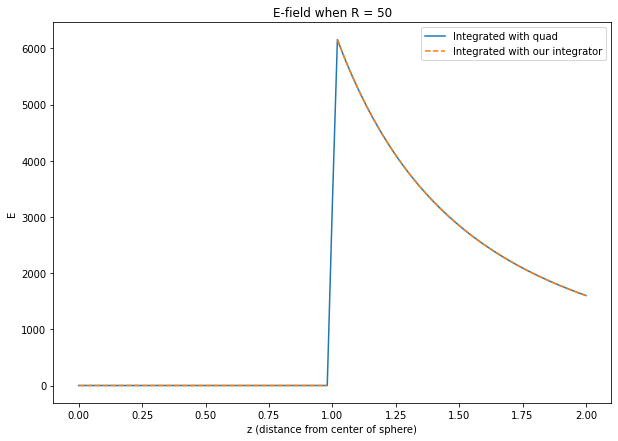

In [5]:
Earr_quad = []
Earr_ours = []

for z in zarr:
    Earr_quad.append(integrate.quad(E(z, R), 0, np.pi)[0])
    if z==R:
        Earr_ours.append(float('nan'))
    else:
        Earr_ours.append(simple_integrator(E(z, R), 0, np.pi, 1e-3)[0])

plt.figure(figsize=(10,7))
plt.plot(zarr, Earr_quad, label="Integrated with quad")
plt.plot(zarr, Earr_ours, label="Integrated with our integrator", ls='--')
plt.legend(loc=0)
plt.xlabel("z (distance from center of sphere)")
plt.ylabel("E")
plt.title("E-field when R = 50")
plt.show()

### Problem 2

In this problem, we can use the recursive function developed in class by Prof. Sievers as our base. We'll work from code similar to the code presented in class here: https://github.com/sievers/phys512-2021/blob/main/integration_odes/integrate_adaptive.py. We can be more efficient than this! The current function calls the function it's integrating multiple times for the same input. We can use the glory of recursion to save intermediate function calls to prevent this from happening. There are other ways of doing this too, but here a form of the Adaptive Simpson's Method is presented as a solution to this problem (https://en.wikipedia.org/wiki/Adaptive_Simpson%27s_method). 

In [6]:
# Sievers' Simple Integrator

def simple_integrate(fun,a,b,tol):
    x=np.linspace(a,b,5)
    y=fun(x)
    neval=len(x) #let's keep track of function evaluations
    f1=(y[0]+4*y[2]+y[4])/6.0*(b-a)
    f2=(y[0]+4*y[1]+2*y[2]+4*y[3]+y[4])/12.0*(b-a)
    myerr=np.abs(f2-f1)
    if (myerr<tol):
        #return (f2)/1.0,myerr,neval
        return (16.0*f2-f1)/15.0,myerr,neval
    else:
        mid=0.5*(b+a)
        f_left,err_left,neval_left=simple_integrate(fun,a,mid,tol/2.0)
        f_right,err_right,neval_right=simple_integrate(fun,mid,b,tol/2.0)
        neval=neval+neval_left+neval_right
        f=f_left+f_right
        err=err_left+err_right
        return f,err,neval

In [7]:
# Our Better Integrator

def better_integrate(fun, a, b, tol, neval=0, fa='', fb='', fm=''):
    x=np.linspace(a, b, 5)
    if neval == 0:
        y=fun(x)
        fa = y[0]
        fm = y[2]
        fb = y[4]
        fm_left = y[1]
        fm_right = y[3]
        neval=len(x) 
    else:
        fm_left = fun(x[1])
        fm_right = fun(x[3])
        neval=2
    f1=(fa+4*fm+fb)/6.0*(b-a)
    f2=(fa+4*fm_left+2*fm+4*fm_right+fb)/12.0*(b-a)
    myerr=np.abs(f2-f1)
    if (myerr<tol):
        return (16.0*f2-f1)/15.0, myerr, neval
    else:
        mid=0.5*(b+a)
        f_left, err_left, neval_left = better_integrate(fun, a, mid, tol/2.0, neval, fa, fm, fm_left)
        f_right, err_right, neval_right = better_integrate(fun, mid, b, tol/2.0, neval, fm, fb, fm_right)
        neval= neval + neval_left + neval_right
        f = f_left + f_right
        err = err_left + err_right
        return f, err, neval

In [8]:
# Let's compare the number of function evaluations between our function and Sievers' with a few examples:

def fun1(x):
    return 1.0/(1.0+x**2)

def fun2(x, sig=1):
    return 1.0+np.exp(-0.5*x**2/(sig**2))

def fun3(x):
    return np.sin(x)

def fun4(x):
    return 3**(x)

def fun5(x):
    return np.sin(x**4)*x

funs = [fun1, fun2, fun3, fun4, fun5]
funs_strings = ["1.0/(1.0+x**2)", "1.0+np.exp(-0.5*x**2/(sig**2))", "np.sin(x)", "3**(x)", "np.sin(x**4)*x"]
limits = [(-1, 1), (-2, 2), (-1, 2), (0, np.pi), (0.5, 1.5)]

for fun, fun_string, lim in zip(funs, funs_strings, limits):
    f_better, err_better, neval_better = better_integrate(fun, lim[0], lim[1], 1e-3)
    f_simple, err_simple, neval_simple = simple_integrate(fun, lim[0], lim[1], 1e-3)
    print("For the function, {}, integrated between {},".format(fun_string, lim))
    print("better_integrate uses {} function evaluations while simple_integrate used {}.".format((neval_better),(neval_simple)))
    print("Our method, better_integrate, saved {} function calls. \n \n".format(neval_simple-neval_better))
#     print("err_better = {}, err_simple = {}".format((err_better), (err_simple)))
#     print("f_better = {}, f_simple = {}".format((f_better), (f_simple)))
    

For the function, 1.0/(1.0+x**2), integrated between (-1, 1),
better_integrate uses 17 function evaluations while simple_integrate used 35.
Our method, better_integrate, saved 18 function calls. 
 

For the function, 1.0+np.exp(-0.5*x**2/(sig**2)), integrated between (-2, 2),
better_integrate uses 33 function evaluations while simple_integrate used 75.
Our method, better_integrate, saved 42 function calls. 
 

For the function, np.sin(x), integrated between (-1, 2),
better_integrate uses 17 function evaluations while simple_integrate used 35.
Our method, better_integrate, saved 18 function calls. 
 

For the function, 3**(x), integrated between (0, 3.141592653589793),
better_integrate uses 29 function evaluations while simple_integrate used 65.
Our method, better_integrate, saved 36 function calls. 
 

For the function, np.sin(x**4)*x, integrated between (0.5, 1.5),
better_integrate uses 29 function evaluations while simple_integrate used 65.
Our method, better_integrate, saved 36 func

### Problem 3

We want to write a function modelling $\log_2$ valid from 0.5 to 1 with an accuracy better than $10^{-6}$. For this we'll use a truncated Chebyshev polynomial fit. Recall Chebyshev polynomials are:

$$P_0(x) = 1$$
$$P_1 (x) = x$$
$$P_{n+1} (x) = 2xP_n(x) - P{n-1} (x) \quad (n > 0)$$

We can use the [numpy chebfit](https://numpy.org/doc/stable/reference/generated/numpy.polynomial.chebyshev.chebfit.html#numpy.polynomial.chebyshev.chebfit) function to do the fit!

Note we also need to translate the range of our data to the range of the chebyshev polynomials, which is easy to do considering the equations
$$x_{\text{Cheby, min}} = ax_{\text{data, min}} + b$$
$$x_{\text{Cheby, max}} = ax_{\text{data, max}} + b$$
And the equation can be constructed after solving for $a$ and $b$
$$x_{\text{Cheby}} = ax_{\text{data}} + b$$

In [9]:
def map_to_chebyshev_boundaries(x):
    '''
    Linearly map values in x to be within the chebyshev range -1 to 1
    
    PARAMETERS:
    -----------
    x : array-like
        The array of x values in your data points
    
    RETURNS:
    --------
    x_mapped : array-like
        The array of x values mapped linearly to the chebyshev domain
    '''
    # Mapping using y = a*x + b where x and y are data and Chebyshev locations 
    # respectively
    cheby_min = -1
    cheby_max = 1
    a = (cheby_max - cheby_min)/(x.max() - x.min())
    b = cheby_min - a*x.min()
    x_mapped = a*x + b
    return x_mapped

Let's try a basic Chebyshev fit just to test our functions. We'll use five Chebyshev polynomials, and plot the residuals to make sure everything works as expected.

In [10]:
# Create an array of x values
npt = 1001
x = np.linspace(0.5, 1, npt)
x_cheb = map_to_chebyshev_boundaries(x)
# Make a matrix for the real data values
y = np.log2(x)
# Choose a degree for cheby fit
deg = 5
# Get the chebyshev coefficients using the numpy function
coeffs = np.polynomial.chebyshev.chebfit(x_cheb, y, deg)
# Evaluate the chebyshev fit. Could write out a function to do this
# (not a bad idea to get familiar with writing out equation!) but I'll
# use the numpy `chebval` to evaluate easily.
y_cheb = np.polynomial.chebyshev.chebval(x_cheb, coeffs)

Now we'll plot the residuals to see how it does

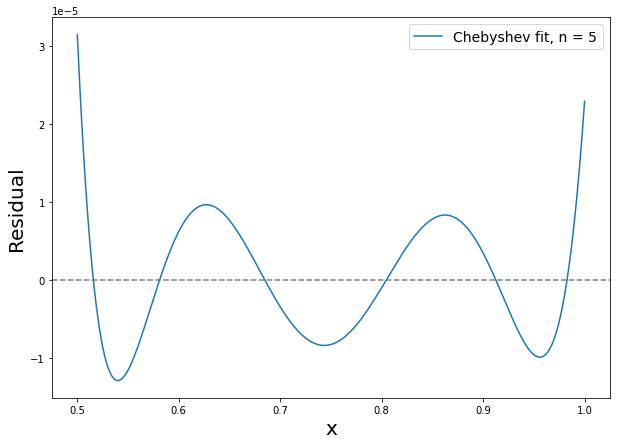

In [11]:
plt.figure(figsize=(10,7))
plt.axhline(0, color = "grey", linestyle="--")
plt.plot(x, y_cheb-y, label="Chebyshev fit, n = {}".format(deg))
plt.xlabel("x",fontsize=20)
plt.ylabel("Residual",fontsize=20)
plt.legend(fontsize="14")
plt.show()

In [12]:
# Check out the maximum error
abs(y_cheb-y).max()

3.1431214363886184e-05

Great! Our fit looks good, and the residual has an expected sinusoidal behaviour due to the Chebyshev polynomails being defined by the double angle formula. Now, we must have accuracy better than $10^{-6}$ in the region. Let's fit a high order polynomial $n=150$, and figure out how many terms we need to retain this accuracy.

In [13]:
# Re-evaluating like before with 50 terms
deg = 150
coeffs = np.polynomial.chebyshev.chebfit(x_cheb, y, deg)
y_cheb = np.polynomial.chebyshev.chebval(x_cheb, coeffs)

In [14]:
# Check out the maximum error
abs(y_cheb-y).max()

6.106226635438361e-15

In [15]:
# Let's figure out how many truncated terms we need to get 
n_trunc = 1
y_cheb_trunc = np.polynomial.chebyshev.chebval(x_cheb, coeffs[:n_trunc])
print("Max error for n_trunc = {} is {}".format(n_trunc, abs(y_cheb_trunc-y).max()))
# Write a for loop whose condition is that we need the error to be within
# 1e-6 tolerance
while abs(y_cheb_trunc-y).max() > 1e-6 and n_trunc <= deg:
    n_trunc = n_trunc + 1
    y_cheb_trunc = np.polynomial.chebyshev.chebval(x_cheb, coeffs[:n_trunc])
    print("Max error for n_trunc = {} is {}".format(n_trunc, abs(y_cheb_trunc-y).max()))
print("Number of polynomials truncated from n = {} Chebyshev fit required for error within 1e-6: {}".format(deg,n_trunc))

Max error for n_trunc = 1 is 0.5431066063272338
Max error for n_trunc = 2 is 0.048051933767788935
Max error for n_trunc = 3 is 0.005582956978377851
Max error for n_trunc = 4 is 0.0007252740071655994
Max error for n_trunc = 5 is 0.00010018903134989543
Max error for n_trunc = 6 is 1.4390930105356858e-05
Max error for n_trunc = 7 is 2.1237410203767126e-06
Max error for n_trunc = 8 is 3.196979792008392e-07
Number of polynomials truncated from n = 150 Chebyshev fit required for error within 1e-6: 8


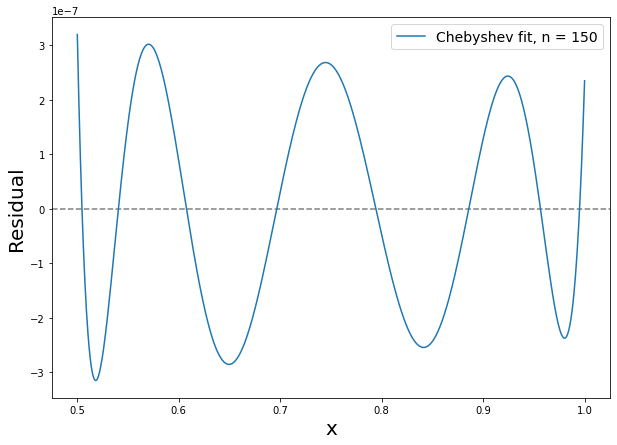

In [16]:
plt.figure(figsize=(10,7))
plt.axhline(0, color = "grey", linestyle="--")
plt.plot(x, y_cheb_trunc-y, label="Chebyshev fit, n = {}".format(deg))
plt.xlabel("x",fontsize=20)
plt.ylabel("Residual",fontsize=20)
plt.legend(fontsize="14")
plt.show()

We can see that the max error for the non-truncated fit is larger, but the RMS error for the non-truncated fit is better. The truncated fit is more consistent, deviating about the same as average at the endpoints.

Now we need to expand this to work on any number. We will use `np.frexp` to do this. What `np.frexp` does is divide any given number into a mantissa $m$ and exponent $\epsilon$:

$$x = m\times 2^{\epsilon}$$

This is very useful for our case of expanding the domain of our `log2` function because when taking the logarithm of a number expanded this way we obtain:

$$y = \log_2 x = log_2 m + \epsilon$$

This decomposition is so useful because the mantissa will always be within the range we already set for our logarithm -- 0.5 to 1!

So, all we have to do to get our function to work for any real number is to take the `frexp` decomposition, use our function on the mantissa $m$ which lies in the range our function works well, and then add the exponent. In order to estimate the log of $m$, we'll note that we can say
$$log_2 m = y - \epsilon$$

In [17]:
# Make a set of x and y values up to large numbers
x_large_range = np.logspace(-5, 5, npt)
y_large_range = np.log2(x_large_range)
m, eps = np.frexp(x_large_range)
m_cheb = map_to_chebyshev_boundaries(m)

In [18]:
# Choose a degree for cheby fit
deg = n_trunc-1
# Get the chebyshev coefficients using the numpy function
coeffs_large_range = np.polynomial.chebyshev.chebfit(m_cheb, y_large_range - eps, deg)
# Evaluate the chebyshev fit. Could write out a function to do this
# (not a bad idea to get familiar with writing out equation!) but I'll
# use the numpy `chebval` to evaluate easily.
y_cheb_large_range = np.polynomial.chebyshev.chebval(m_cheb, coeffs_large_range) + eps

In [19]:
# Check maximum error:
abs(y_cheb_large_range-y_large_range).max()

6.987446301565114e-07

OK! Things still look like they're working using a large range of values and `frexp`. Let's check the error on the fit:

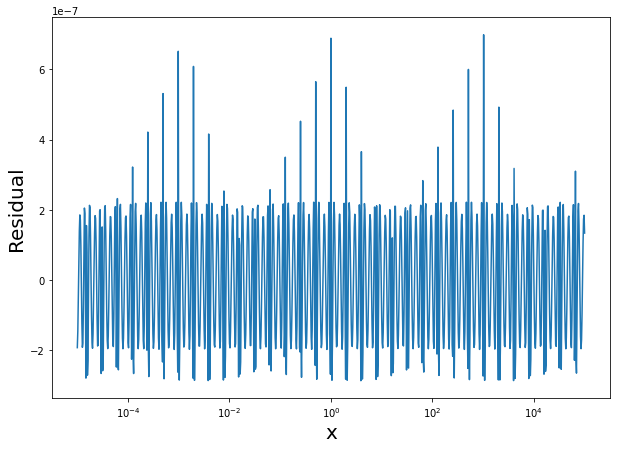

Max error for large range: 6.987446301565114e-07
RMS error for large range: 1.6913345430551744e-07


In [20]:
# Ensure our fit does a good job for the large range of x values
residuals_large_range = y_cheb_large_range - y_large_range
plt.figure(figsize=(10,7))
plt.semilogx(x_large_range, residuals_large_range)
plt.xlabel("x",fontsize=20)
plt.ylabel("Residual",fontsize=20)
plt.show()
print("Max error for large range: {}".format(residuals_large_range.max()))
print("RMS error for large range: {}".format(residuals_large_range.std()))